# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [5]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6295 (from 2)
Receiving objects: 100% (6559/6559), 116.26 MiB | 48.02 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [ ]:
import os
import torch
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}!")

In [7]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple
import copy
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
!pip install visualkeras



from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np


from torch.optim import Adam, AdamW, SGD, lr_scheduler
from torch.utils.data import random_split, DataLoader
from torchvision import transforms as T, datasets, models
from torchsummary import summary

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 20.9 MB/s eta 0:00:0000:01


In [8]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    for seed_func in (np.random.seed, random.seed, torch.manual_seed, torch.cuda.manual_seed):
        seed_func(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    s = torch.initial_seed() % 2**32
    for seed_func in (np.random.seed, random.seed):
        seed_func(s)

# seed 42 is a reference to Hitchhiker's Guide to the Galaxy
seed = 42
g = torch.Generator().manual_seed(seed)
fix_random(seed)

In [9]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [10]:
# Create the dataset objects
train_dataset = GroceryStoreDataset(split='train', transform=T.ToTensor())
val_dataset = GroceryStoreDataset(split='val', transform=T.ToTensor())
test_dataset = GroceryStoreDataset(split='test', transform=T.ToTensor())

Navigating the Dataset object!!

In [11]:
from PIL import Image
from IPython.display import display
img,no=val_dataset.__getitem__(220)
display(img)
print(no)

tensor([[[0.6588, 0.8941, 0.8588,  ..., 0.1176, 0.1176, 0.1137],
         [0.6431, 0.8745, 0.8706,  ..., 0.1176, 0.1176, 0.1137],
         [0.6039, 0.8314, 0.8784,  ..., 0.1176, 0.1176, 0.1137],
         ...,
         [0.3647, 0.3451, 0.3490,  ..., 0.4863, 0.4784, 0.4706],
         [0.3529, 0.3451, 0.3569,  ..., 0.4863, 0.4863, 0.4863],
         [0.3490, 0.3451, 0.3608,  ..., 0.4667, 0.4745, 0.4784]],

        [[0.6314, 0.8667, 0.8392,  ..., 0.1373, 0.1373, 0.1333],
         [0.6157, 0.8471, 0.8510,  ..., 0.1373, 0.1373, 0.1333],
         [0.5765, 0.8039, 0.8588,  ..., 0.1373, 0.1373, 0.1333],
         ...,
         [0.3725, 0.3529, 0.3569,  ..., 0.4431, 0.4353, 0.4275],
         [0.3608, 0.3529, 0.3647,  ..., 0.4431, 0.4392, 0.4392],
         [0.3569, 0.3529, 0.3686,  ..., 0.4235, 0.4314, 0.4353]],

        [[0.6000, 0.8353, 0.8235,  ..., 0.1529, 0.1529, 0.1490],
         [0.5843, 0.8235, 0.8353,  ..., 0.1529, 0.1529, 0.1490],
         [0.5529, 0.7804, 0.8431,  ..., 0.1529, 0.1529, 0.

36


### **Create a table for cross referencing the object type with label**

In [12]:
import pandas as pd
def create_dataframe(dataset):
    # Read file and create dataframe
    annot = dataset.read_file()
    df = pd.DataFrame(list(zip(*annot)), columns=['name', 'label'])
    # Split the path into multiple columns
    df[['Set', 'Category', 'Type', 'Subtype', 'File']] = df['name'].str.split("/", expand=True)
    mask = df['Subtype'].str.contains(r'\.jpg$', na=False)
    df.loc[mask, 'File'] = df.loc[mask, 'Subtype']
    df.loc[mask, 'Subtype'] = None

    # Reorder columns
    df = df[['Set', 'Category', 'Type', 'Subtype', 'File', 'label']]
    label_to_name = df.drop_duplicates(subset='label').set_index('label')['Type'].to_dict()
    return df,label_to_name

# Apply the function to all datasets
val_df,_ = create_dataframe(val_dataset)
train_df,label_to_name = create_dataframe(train_dataset)
test_df,_ = create_dataframe(test_dataset)

In [13]:
label_to_name

{0: 'Apple',
 1: 'Avocado',
 2: 'Banana',
 3: 'Kiwi',
 4: 'Lemon',
 5: 'Lime',
 6: 'Mango',
 7: 'Melon',
 8: 'Nectarine',
 9: 'Orange',
 10: 'Papaya',
 11: 'Passion-Fruit',
 12: 'Peach',
 13: 'Pear',
 14: 'Pineapple',
 15: 'Plum',
 16: 'Pomegranate',
 17: 'Red-Grapefruit',
 18: 'Satsumas',
 19: 'Juice',
 20: 'Milk',
 21: 'Oatghurt',
 22: 'Oat-Milk',
 23: 'Sour-Cream',
 24: 'Sour-Milk',
 25: 'Soyghurt',
 26: 'Soy-Milk',
 27: 'Yoghurt',
 28: 'Asparagus',
 29: 'Aubergine',
 30: 'Cabbage',
 31: 'Carrots',
 32: 'Cucumber',
 33: 'Garlic',
 34: 'Ginger',
 35: 'Leek',
 36: 'Brown-Cap-Mushroom',
 37: 'Onion',
 38: 'Pepper',
 39: 'Potato',
 40: 'Red-Beet',
 41: 'Tomato',
 42: 'Zucchini'}

In [14]:
val_df

Set    Category      Type           Subtype                      File  \
0    val       Fruit     Apple  Golden-Delicious  Golden-Delicious_001.jpg   
1    val       Fruit     Apple  Golden-Delicious  Golden-Delicious_002.jpg   
2    val       Fruit     Apple  Golden-Delicious  Golden-Delicious_003.jpg   
3    val       Fruit     Apple  Golden-Delicious  Golden-Delicious_004.jpg   
4    val       Fruit     Apple  Golden-Delicious  Golden-Delicious_005.jpg   
..   ...         ...       ...               ...                       ...   
291  val  Vegetables  Zucchini              None          Zucchini_001.jpg   
292  val  Vegetables  Zucchini              None          Zucchini_002.jpg   
293  val  Vegetables  Zucchini              None          Zucchini_003.jpg   
294  val  Vegetables  Zucchini              None          Zucchini_004.jpg   
295  val  Vegetables  Zucchini              None          Zucchini_005.jpg   

     label  
0        0  
1        0  
2        0  
3        0  
4        0  
..     ...  
291     42  
292     42  
293     42  
294     42  
295     42  

[296 rows x 6 columns]

In [15]:
val_dataset.get_num_classes()

43

Lets check the data distribution along the classes in different set!!

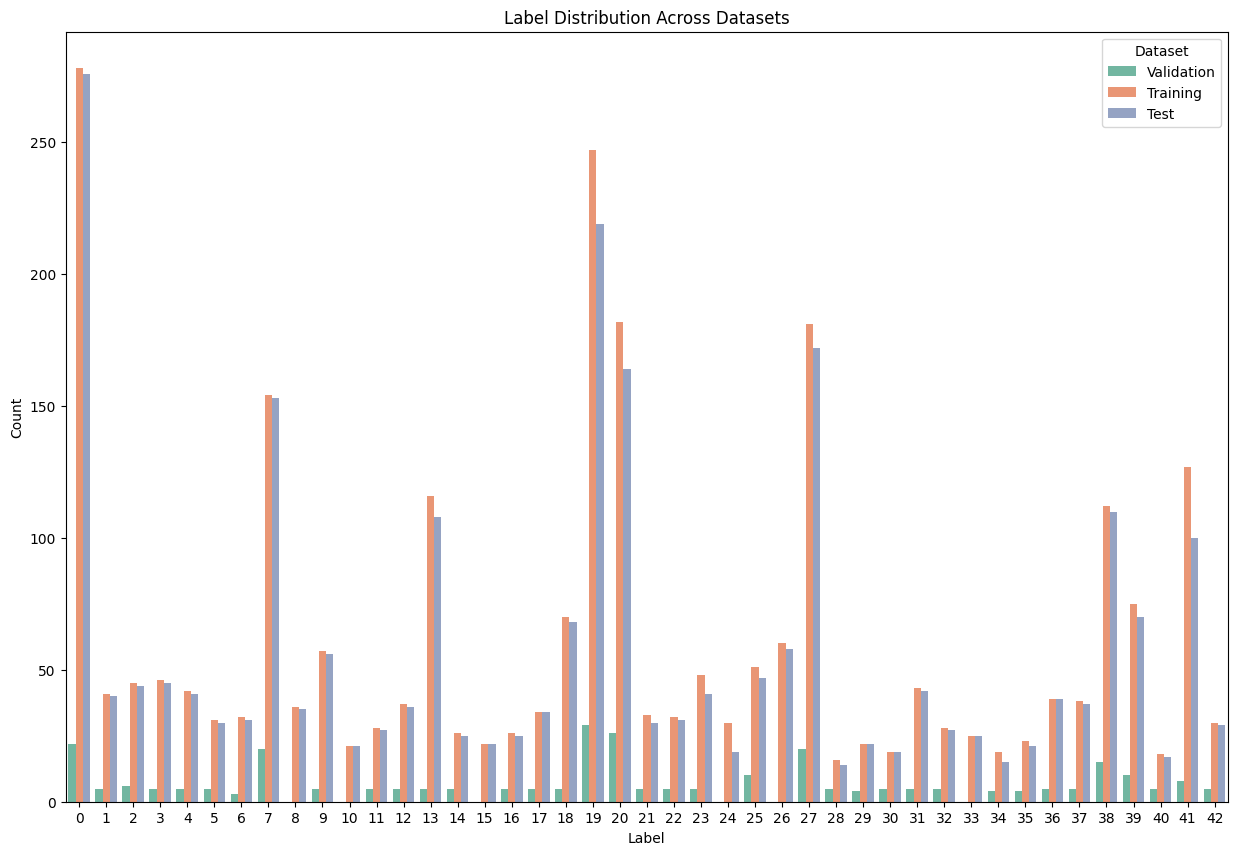

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot(val_df, train_df, test_df):
    # Combine the 'label' column from all DataFrames
    combined_df = pd.concat([
        val_df.assign(dataset='Validation'),
        train_df.assign(dataset='Training'),
        test_df.assign(dataset='Test')
    ])

    # Plot the combined histogram
    plt.figure(figsize=(15, 10))
    sns.countplot(x='label', hue='dataset', data=combined_df, palette='Set2')

    # Set labels and title
    plt.title('Label Distribution Across Datasets')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.legend(title='Dataset')
    plt.show()

# Apply the function to plot all datasets in one histogram
plot(val_df, train_df, test_df)



### **We can see that every class is not uniformly distributed**

Some utility functions

Min Max normalisation for plotting purpose

In [17]:
def min_max_norm(img):

    if torch.min(img) < 0 or torch.max(img) > 1:
        # Normalize the image data to the range [0, 1]
        min_val = torch.min(img)
        max_val = torch.max(img)

        # Avoid division by zero
        if max_val - min_val != 0:
            img = (img - min_val) / (max_val - min_val)
        else:
            img = np.zeros_like(img) 

    return img

In [18]:
def plot_data(dataset, size=None, normalization=False, augmentation=False):


    if not size and not normalization and not augmentation:
        print("No transformation applied to data")
    else:
        print("The Data have: "
        +(f"\nsize = {(size,size)}" if size else "")
        +(f"\nnormalization = {normalization}" if normalization else "")
        +(f"\naugmentation = {augmentation}" if augmentation else "")
        )

    _, ax = plt.subplots(1, 4, figsize=(12, 5))

    np.random.seed(seed)
    indices = np.random.choice(len(dataset), size=4, replace=False)
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        ax[i].imshow(min_max_norm(img).permute(1, 2, 0))
        ax[i].set_title(label_to_name.get(label))
        ax[i].axis("off")

In [19]:
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, epochs, lrs):

    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.4)

    # Left Plot - Loss vs Learning Rate
    ax1 = ax[0].twinx()
    ax[0].plot(range(1, epochs + 1), train_losses, label='Training Loss')
    ax[0].plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    ax1.plot(range(1, epochs + 1), lrs, label='Learning Rate', linestyle='dashed', color='red')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax1.set_ylabel('Learning Rate')
    ax1.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
    ax[0].grid(True)
    lines, labels = ax[0].get_legend_handles_labels()
    lines1, labels1 = ax1.get_legend_handles_labels()
    ax[0].legend(lines + lines1, labels + labels1, loc='best', fontsize=10, framealpha=0.7)

    # Right Plot - Accuracy vs Learning Rate
    ax2 = ax[1].twinx()
    ax[1].plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    ax[1].plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    ax2.plot(range(1, epochs + 1), lrs, label='Learning Rate', linestyle='dashed', color='red')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax2.set_ylabel('Learning Rate')
    ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
    ax[1].grid(True)
    lines, labels = ax[1].get_legend_handles_labels()
    lines1, labels1 = ax2.get_legend_handles_labels()
    ax[1].legend(lines + lines1, labels + labels1, loc='best', fontsize=10, framealpha=0.7)

    plt.show()

In [20]:
def plot_per_class_accuracy(model, best_params, dl):

    # Store results classwise
    num_classes = dl.dataset.get_num_classes()
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    # Run through dataset
    with torch.no_grad():
        for imgs, labels in dl:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            # Process the label - prediction pairs
            for label, pred in zip(labels, preds):
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1

    # Compute and plot accuracy
    class_accuracy = 100 * class_correct / class_total
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(num_classes), class_accuracy, color='green')
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Per Class Accuracy')
    plt.tight_layout()
    plt.show()

In [21]:
def ncorrect(scores, y):
#find all the correct response
    y_pred = torch.argmax(scores, -1)
    return (y_pred == y).sum()

def accuracy(scores, y):
# custom accuracy
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

In [22]:
def train_loop(model, train_dl, epochs, opt, val_dl=None, verbose=False, label_smoothing=0.0, scheduler=False, patience_epochs=50, class_weights=None):

    fix_random(seed=seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Initialize variables to track the best model accuracy and parameters
    best_val_acc = 0
    best_params = []
    best_epoch = -1
    no_improve = 0

    # Define loss function with optional class weights and label smoothing
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)


    # Lists to record training and validation metrics over epochs
    train_losses, val_losses, train_accuracies, val_accuracies, lrs = [], [], [], [], []


    # Iterate over epochs
    for e in tqdm(range(1, epochs + 1)):
        model.train()  

       
        train_loss = 0
        train_samples = 0
        train_acc = 0

       
        lrs.append(opt.param_groups[0]['lr'])

        
        for train_data in train_dl:
            imgs = train_data[0].to(device)  
            labels = train_data[1].to(device) 

            scores = model(imgs)  
            loss = criterion(scores, labels)  
            train_loss += loss.item() * imgs.shape[0] 
            train_samples += imgs.shape[0] 
            train_acc += ncorrect(scores, labels).item()  

            # Perform backpropagation and optimizer step
            opt.zero_grad()  
            loss.backward() 
            opt.step()  

        # Step the scheduler if it is specified
        if scheduler != False:
            scheduler.step()

        # Calculate average training accuracy and loss
        train_acc /= train_samples
        train_loss /= train_samples

        # Record training metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()  
        with torch.no_grad(): 
            val_loss = 0
            val_samples = 0
            val_acc = 0
            if val_dl is not None:
                # Iterate over the validation data loader
                for val_data in val_dl:
                    imgs = val_data[0].to(device)  
                    labels = val_data[1].to(device)  

                    val_scores = model(imgs)  
                    val_loss += criterion(val_scores, labels).item() * imgs.shape[0]  
                    val_samples += imgs.shape[0]  
                    val_acc += ncorrect(val_scores, labels).item()  

                # Calculate average validation accuracy and loss
                val_acc /= val_samples
                val_loss /= val_samples

                # Record validation metrics
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)

            # Save the model if it has the best validation accuracy so far
            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = copy.deepcopy(model.state_dict()) 
                torch.save(best_params, "best_model.pth") 
                best_epoch = e
                no_improve = 0  
            else:
                no_improve += 1  

        # Print progress if verbose mode is enabled
        if verbose and (e - 1) % 5 == 0:
            print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" +
                  ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))

        # Early stopping 
        if no_improve >= patience_epochs:
            print(f"Early stopping at epoch {e}")
            break

    # Print the best epoch and accuracy for val
    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc:.3f}")

    # Plot training and validation results
    plot_results(train_losses, val_losses, train_accuracies, val_accuracies, e, lrs)

    return best_val_acc, best_params, best_epoch 





In [23]:
def test_model(model, best_params, dl, plot=True, samples=None):

    model.load_state_dict(best_params)  
    model.eval()  

    with torch.no_grad():  
        correct = 0
        total = 0
        for imgs, labels in dl:
            imgs = imgs.to(device)  
            labels = labels.to(device)  
            outputs = model(imgs)  
            total += imgs.shape[0]  
            correct += ncorrect(outputs, labels).item()  

   
        print(f'Test Accuracy: {(100 * correct / total):.2f}%')

    if plot: plot_per_class_accuracy(model, best_params, dl)

    if samples:
        # create plotting grid
        cols = 4
        rows = int(np.ceil(samples / cols))
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        axs = axs.ravel()
        if samples == 1:  
            axs = [axs]
            
        np.random.seed(seed)
        indices = np.random.choice(len(dl.dataset), size=samples, replace=False)

        with torch.no_grad():
            for i, idx in enumerate(indices):
                img, label = dl.dataset[idx]
                img_device = img.unsqueeze(0).to(device) 
                output = model(img_device)
                prediction = torch.argmax(output, dim=1).item()

                img_np = min_max_norm(img.permute(1, 2, 0)).cpu().numpy()  

                axs[i].imshow(img_np)
                axs[i].axis('off')
                true_label = label_to_name[label]
                pred_label = label_to_name[prediction]
                axs[i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)

        plt.tight_layout()
        plt.show()

In [24]:
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(df, label_col='label'):
    """
    Compute class weights for a dataset stored in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing a column with labels.
        label_col (str): The column name containing the class labels.

    Returns:
        dict: A dictionary mapping each class to its computed weight.
    """
    # Obtain the unique classes
    classes = np.unique(df[label_col])
    # Compute the class weights using 'balanced' mode (weights inversely proportional to class frequency)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=df[label_col])
    return dict(zip(classes, weights))

In [25]:
class_weight=get_class_weights(train_df)

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

## **Baseline Model** ##

## Data Preperation ##

In [26]:
def get_mean_std(dataset):
# Normalise the images before feeding to models
    sums, sq_sums, counts = [], [], []
    for img, _ in dataset:
        # Normalize pixel values to [0, 1]
        img = img.numpy() / 255.0
        c, h, w = img.shape
        sums.append(img.reshape(c, -1).sum(axis=1))
        sq_sums.append((img.reshape(c, -1) ** 2).sum(axis=1))
        counts.append(h * w)

    total_pixels = np.sum(counts)
    total_sum = np.sum(sums, axis=0)
    total_sq_sum = np.sum(sq_sums, axis=0)

    mean = total_sum / total_pixels
    std = np.sqrt(total_sq_sum / total_pixels - mean ** 2)
    return mean, std

**For the base-line model, we start with following actions:**
1. we start with 64 X 64 resolution which makes training faster

2. As suggested in Yann LeCunn's paper: "Efficient Backprop", Convergence is faster if the average of input variable is closer to zero, we applied get_mean_std() function to normalise the input dataset

The Data have: 
size = (64, 64)
normalization = True


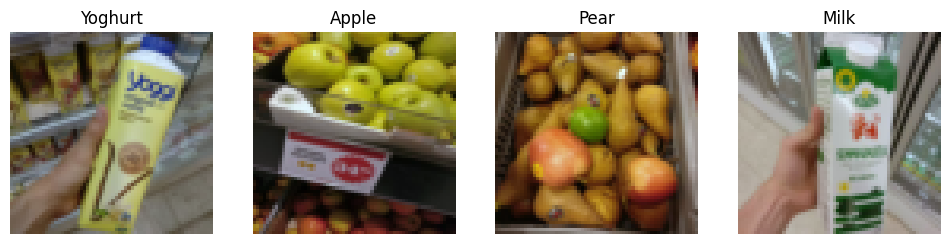

In [27]:
import torchvision.transforms as T
mean,std=get_mean_std(train_dataset)
n_classes = train_dataset.get_num_classes()
size = 64

transform = T.Compose([
    T.Resize((size,size)),
    T.ToTensor(),
    T.Normalize(mean, std)
])

train_dataset = GroceryStoreDataset(split='train', transform=transform)
val_dataset = GroceryStoreDataset(split='val', transform=transform)
test_dataset = GroceryStoreDataset(split='test', transform=transform)

plot_data(train_dataset, size=size, normalization=True)

## Hyper Parameter ##

The **Batch size** is found after experimenting with 32, 64 and 128, batch size=32 leads to a lot of oscillation in the loss curve, whereas batch size=128 takes extra time to reaches comparably better result.

In [28]:
batch_size=64
num_workers=4
learning_rate = 10**(-3)
max_epochs = 50

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
test_dl = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [29]:
results = {}

In [30]:
import torch
import torch.nn as nn

class Baseline(nn.Module):
    """
    Base line model with fully connected layers.
    """
    def __init__(self, n_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(3 * 64 * 64, 8192),
            nn.ReLU(inplace=True),
            nn.Linear(8192, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 768),  # Extra layer added here
            nn.ReLU(inplace=True),
            nn.Linear(768, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.features(x)
        x = self.classifier(x)
        return x

    def get_name(self):
        return "Baseline"


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 104.858 - train acc 0.058 - valid loss 3.854 - valid acc 0.088
Epoch 6: train loss 2.671 - train acc 0.223 - valid loss 2.986 - valid acc 0.186
Early stopping at epoch 9
Best epoch 4, best acc 0.206


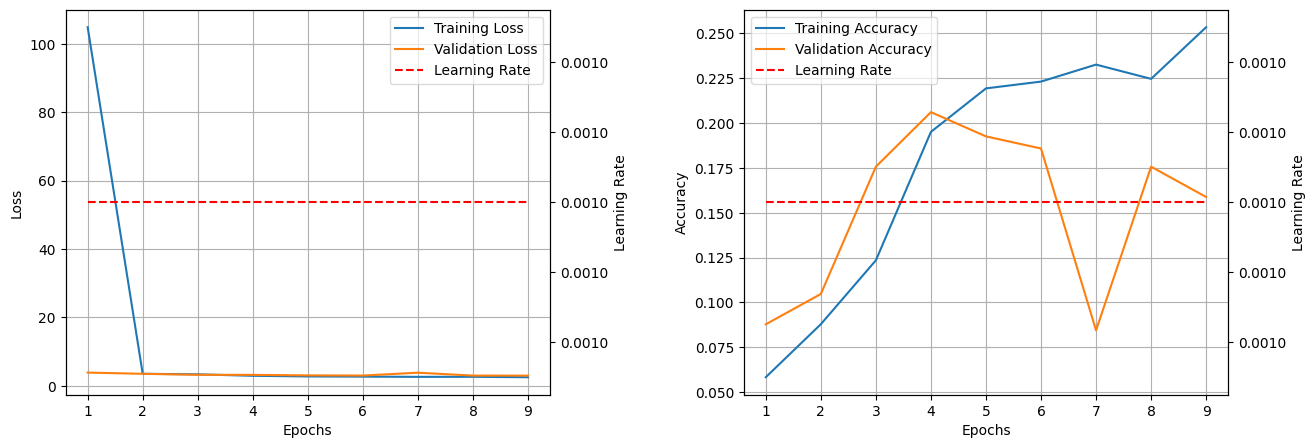

In [31]:
# Initialize the model, loss function, and optimizer
model = Baseline(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    patience_epochs=5)

In [32]:
params = {
    'input size': size,
    'learning rate': learning_rate,
    'regularization': None,
    'avg pool': False,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
results[model.get_name()] = params

In [33]:
results

{'Baseline': {'input size': 64,
  'learning rate': 0.001,
  'regularization': None,
  'avg pool': False,
  'validation accuracy': 0.20608108108108109,
  'epoch': 4}}

In [34]:
def get_param(model):
    """
    Extract parameters from a model instance.

    Args:
        model (nn.Module): The model instance from which to extract parameters.

    Returns:
        dict: Dictionary containing the model parameters.
    """
    params = {
        'model name': model.get_name() if hasattr(model, 'get_name') else type(model).__name__,
        'input size': size,
        'learning rate': getattr(model, 'learning_rate', None),
        'regularization': getattr(model, 'regularization', None),
        'avg pool': getattr(model, 'avg_pool', False),
        'validation accuracy': getattr(model, 'best_val_acc', None),
        'epoch': getattr(model, 'best_epoch', None)
    }
    return params

In [35]:
model_summary = get_param(model)
models_summary[model_summary['model name']] = model_summary

NameError: name 'models_summary' is not defined

Experimentation with 128 x 128 input size

The Data have: 
size = (128, 128)
normalization = True


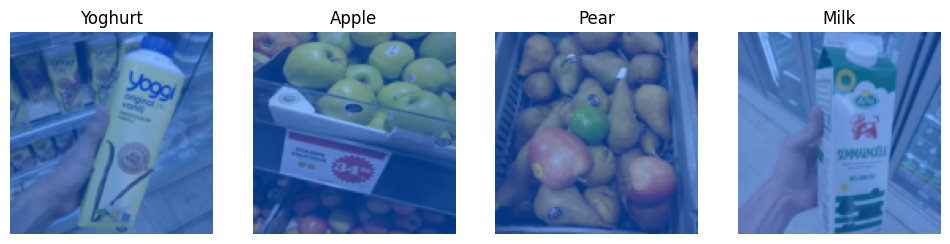

In [36]:
import torchvision.transforms as T
mean,std=get_mean_std(train_dataset)
n_classes = train_dataset.get_num_classes()
size = 128

transform = T.Compose([
    T.Resize((size,size)),
    T.ToTensor(),
    T.Normalize(mean, std)
])

train_dataset_128 = GroceryStoreDataset(split='train', transform=transform)
val_dataset_128 = GroceryStoreDataset(split='val', transform=transform)
test_dataset_128 = GroceryStoreDataset(split='test', transform=transform)

plot_data(train_dataset_128, size=size, normalization=True)

In [37]:
batch_size=64
num_workers=4
learning_rate = 10**(-3)
max_epochs = 50

train_dl_128 = DataLoader(
    train_dataset_128,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
val_dl_128 = DataLoader(
    val_dataset_128,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
test_dl_128 = DataLoader(
    test_dataset_128,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [38]:
import torch
import torch.nn as nn

class Baseline_128(nn.Module):
    """
    Base line model with fully connected layers.
    """
    def __init__(self, n_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(3 * 128 * 128, 8192),
            nn.ReLU(inplace=True),
            nn.Linear(8192, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 768),  # Extra layer added here
            nn.ReLU(inplace=True),
            nn.Linear(768, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.features(x)
        x = self.classifier(x)
        return x

    def get_name(self):
        return "Baseline_128"


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 4.762 - train acc 0.089 - valid loss 3.561 - valid acc 0.074
Epoch 6: train loss 3.388 - train acc 0.102 - valid loss 3.614 - valid acc 0.074
Early stopping at epoch 7
Best epoch 2, best acc 0.098


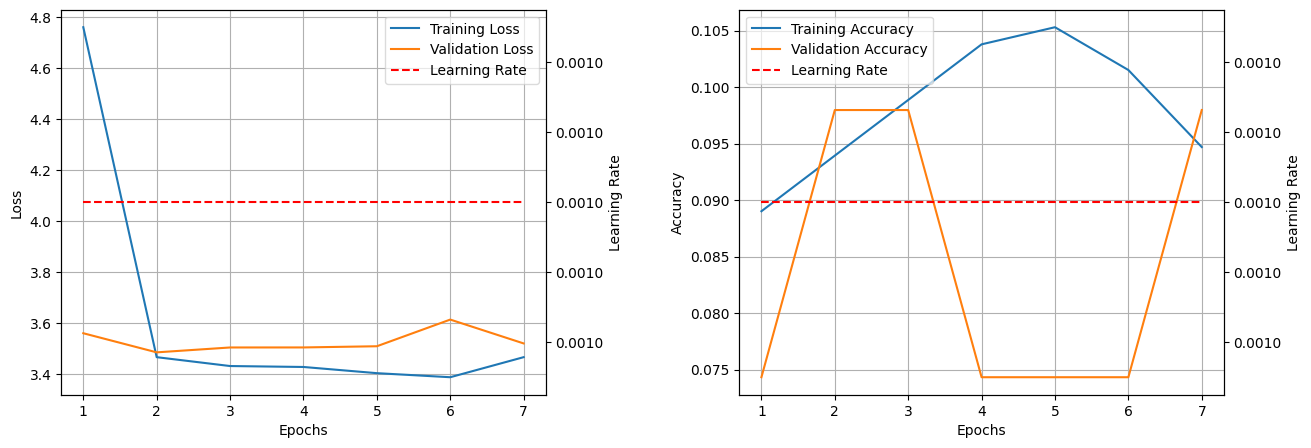

In [39]:
# Initialize the model, loss function, and optimizer
model = Baseline_128(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl_128,
    max_epochs,
    optimizer,
    val_dl_128,
    verbose=True,
    patience_epochs=5)

In [40]:
params = {
    'input size': size,
    'learning rate': learning_rate,
    'regularization': None,
    'avg pool': False,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
results[model.get_name()] = params

As we learned in the class, Fully connected networks consider each pixel individually. therefore increasing the image size adversely effect the performance of the model,which can be related to overfitting of the model.

## **VGG style network** ##

Based on the stage based design of the VGG network, we proceed with following stage design:
* 3x3 convolutions, S=1, P=1
*  2x2 max-pooling, S=2, P=0
*  #channels doubles after each pool
  [Based on the IPCV slides]


In [41]:
class Model1(nn.Module):
  '''
  A VGG inspired model.
  '''
  def __init__(self, n_classes: int):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 32x32x64

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 16x16x128

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 8x8x256

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 4x4x512
    )
    self.classifier = nn.Sequential(
        nn.Linear(4*4*512, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, n_classes)
    )

  def forward(self, x):
      x = self.features(x) # Feature extractor backbone
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

  def get_name(self):
      return "Model1"

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 10.926 - train acc 0.159 - valid loss 3.008 - valid acc 0.169
Epoch 6: train loss 0.818 - train acc 0.724 - valid loss 3.746 - valid acc 0.291
Early stopping at epoch 10
Best epoch 5, best acc 0.307


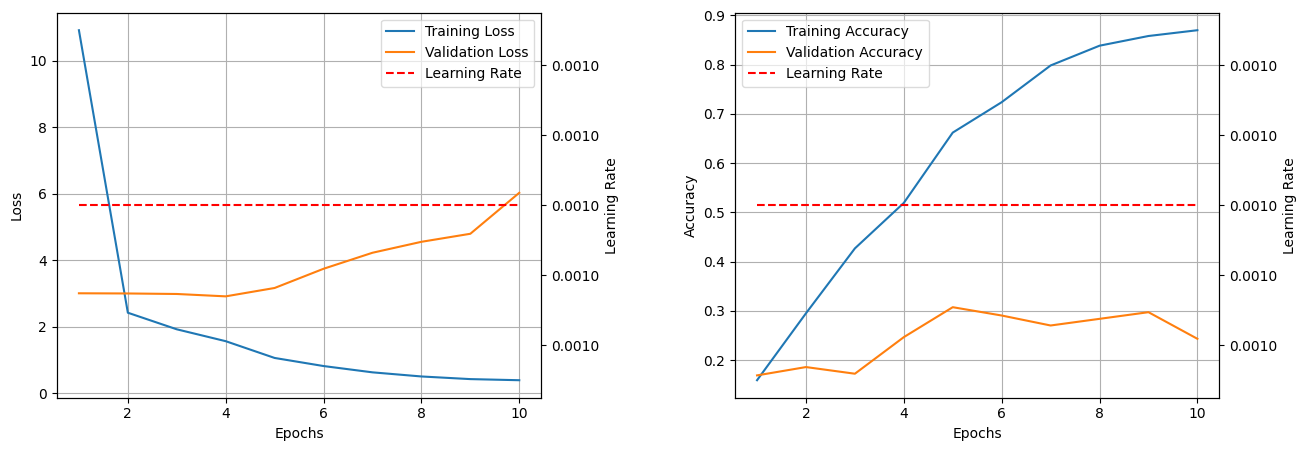

In [45]:
# Initialize the model, loss function, and optimizer
model = Model1(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    patience_epochs=5)

In [46]:
params = {
    'input size': size,
    'learning rate': learning_rate,
    'regularization': None,
    'avg pool': False,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
results[model.get_name()] = params

In [47]:
results

{'Baseline': {'input size': 64,
  'learning rate': 0.001,
  'regularization': None,
  'avg pool': False,
  'validation accuracy': 0.20608108108108109,
  'epoch': 4},
 'Baseline_128': {'input size': 128,
  'learning rate': 0.001,
  'regularization': None,
  'avg pool': False,
  'validation accuracy': 0.09797297297297297,
  'epoch': 2},
 'Model1': {'input size': 128,
  'learning rate': 0.001,
  'regularization': None,
  'avg pool': False,
  'validation accuracy': 0.30743243243243246,
  'epoch': 5}}

From the Graph above, we can see that the vaalidation loss is increasing, which is an indication of overfitting.

We will now try some of the measures to add regularization by adding:
* Dropout
* Dropout + Global Average pooling
* Dropout + Global Average Pooling + Batch Normalisation

## **Adding Dropout** ##

Two main site for adding drop out layer is after activation function (ReLU) and before linear layers in fully connected layers (Classifier).

During our experimentation, we found that Classifier is more prone to overfitting, hence placing dropout before linear layers are the best.

On the other hand adding dropout before activation function in feature selection part leads to drop in performance.

In [48]:
class Model2(nn.Module):
  '''
  A model inspired by VGG with dropout regularization.
  '''
  def __init__(self, n_classes: int):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 32x32x64

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 16x16x128

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 8x8x256

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), # out: 4x4x512
    )
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5), 
        nn.Linear(4*4*512, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5), 
        nn.Linear(1024, n_classes)
    )

  def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

  def get_name(self):
      return "Model2"

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 7.351 - train acc 0.143 - valid loss 3.225 - valid acc 0.162
Epoch 6: train loss 1.578 - train acc 0.497 - valid loss 2.508 - valid acc 0.270
Early stopping at epoch 10
Best epoch 5, best acc 0.324


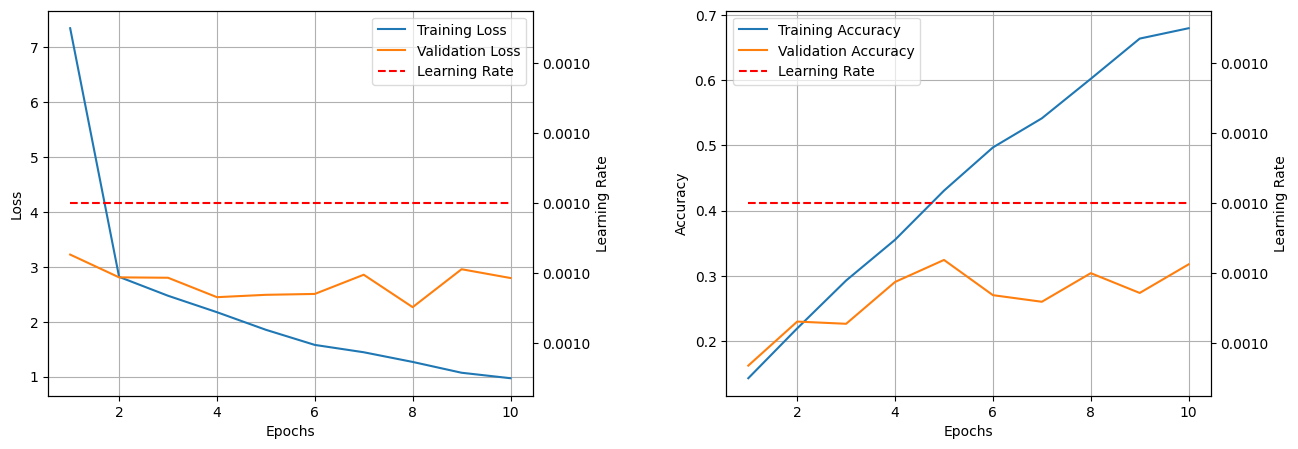

In [49]:
# Initialize the model, loss function, and optimizer
model = Model2(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    patience_epochs=5
)

In [50]:
params = {
    'input size': size,
    'learning rate': learning_rate,
    'regularization': 'dropout',
    'avg pool': False,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
results[model.get_name()] = params

## **Global average pooling** ##

 To capture the most prominent feature in the entire feature map, irrespective of its position, we add Global Average pooling right before the classifier (fully connected layers)

In [51]:
class Model3(nn.Module):
  '''
  A VGG inspired CNN with dropout regularization in the classifier and global average pooling on the final feature extractor.
  '''
  def __init__(self, n_classes: int):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), 

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), 

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1, 1)) 
    )
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(512, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(1024, n_classes)
    )

  def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

  def get_name(self):
      return "Model3"

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 4.133 - train acc 0.120 - valid loss 3.126 - valid acc 0.240
Epoch 6: train loss 1.929 - train acc 0.407 - valid loss 2.273 - valid acc 0.287
Epoch 11: train loss 1.033 - train acc 0.659 - valid loss 2.788 - valid acc 0.338
Epoch 16: train loss 0.680 - train acc 0.774 - valid loss 2.771 - valid acc 0.368
Epoch 21: train loss 0.462 - train acc 0.843 - valid loss 3.344 - valid acc 0.355
Early stopping at epoch 25
Best epoch 20, best acc 0.426


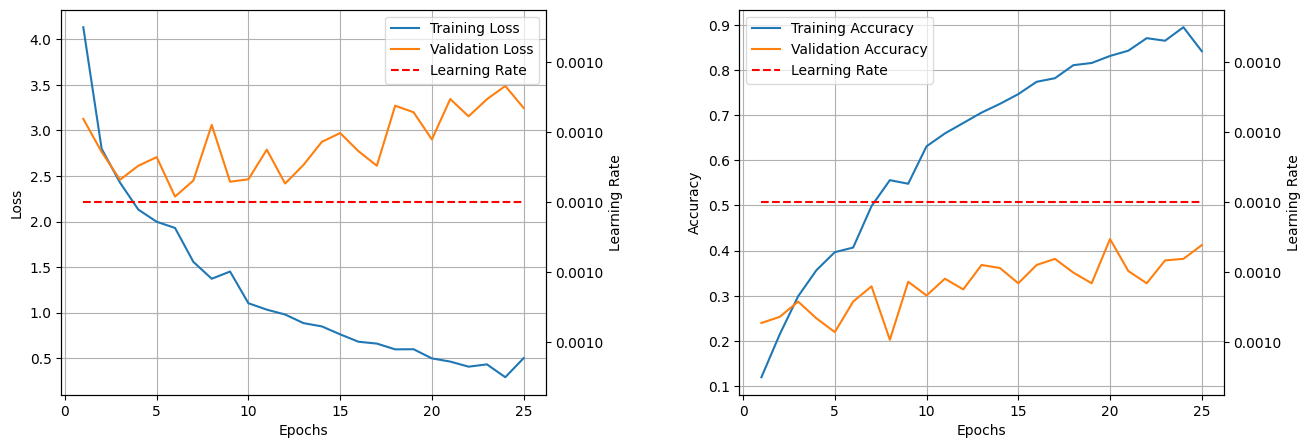

In [52]:
# Initialize the model, loss function, and optimizer
model = Model3(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc, best_params, best_epoc = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    patience_epochs=5
)

In [53]:
params = {
    'input size': size,
    'learning rate': learning_rate,
    'regularization': 'dropout',
    'avg pool': True,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
results[model.get_name()] = params

## **Batch Normalisation** ##

There are multiple places where we can add the batch noemalisation. 
* **After Conv2d and before ReLU**, the rationale in such implementation is Batch Normalisation normalises the output from convolution layer, such that the input to activation layer is centered around zero, making activation layer more effective.
* **After Activation and before pooling** This idea is that the activation function (like ReLU) introduces non-linearity, and normalizing after it ensures that the values fed into subsequent layers are well-scaled.

Based on our experimentation we found out that placing Batch Normalisation after conv2d and ReLU helps in faster convergence.

In [54]:
class Model4(nn.Module):
  '''
  A VGG inspired CNN with dropout regularization + global average pooling + batch normalization before the activation function.
  '''
  def __init__(self, n_classes: int):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), 
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), 
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), 
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), 
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1, 1))
    )
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(512, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(1024, n_classes)
    )

  def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

  def get_name(self):
      return "Model4"

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 2.746 - train acc 0.239 - valid loss 2.527 - valid acc 0.260
Epoch 6: train loss 1.107 - train acc 0.616 - valid loss 1.807 - valid acc 0.443
Epoch 11: train loss 0.660 - train acc 0.783 - valid loss 3.017 - valid acc 0.358
Epoch 16: train loss 0.395 - train acc 0.871 - valid loss 2.087 - valid acc 0.524
Epoch 21: train loss 0.349 - train acc 0.883 - valid loss 2.893 - valid acc 0.429
Early stopping at epoch 22
Best epoch 17, best acc 0.534


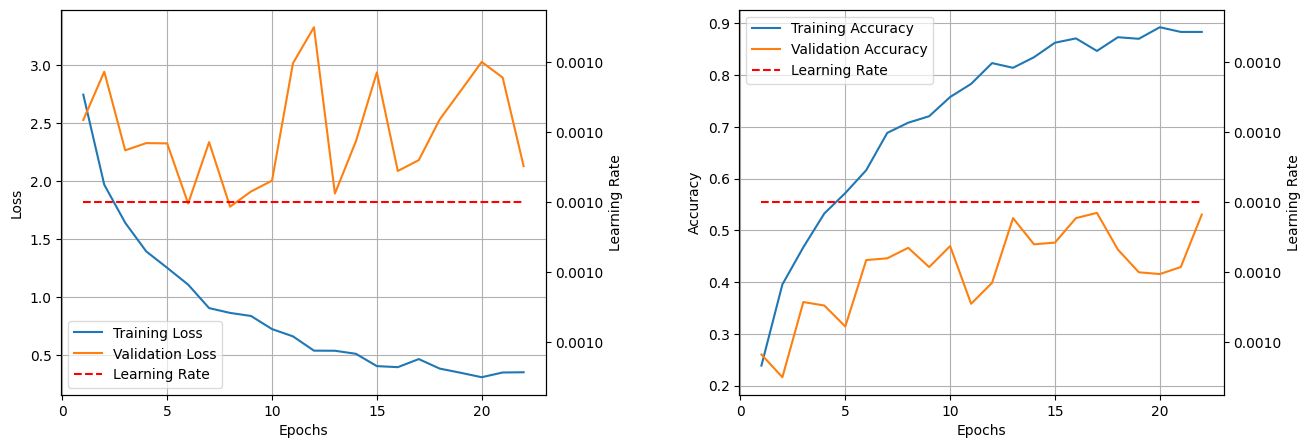

In [55]:
# Initialize the model, loss function, and optimizer
model = Model4(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    patience_epochs=5
)

In [56]:
params = {
    'input size': size,
    'learning rate': learning_rate,
    'regularization': 'dropout, batch norm',
    'avg pool': True,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
results[model.get_name()] = params

## **Learning rate scheduler** ##

There are multiple Learning rate scheduler, we would experiment with:
* Step
* Exponential

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 2.785 - train acc 0.238 - valid loss 2.491 - valid acc 0.264
Epoch 6: train loss 1.003 - train acc 0.650 - valid loss 2.177 - valid acc 0.341
Epoch 11: train loss 0.603 - train acc 0.793 - valid loss 1.722 - valid acc 0.514
Epoch 16: train loss 0.341 - train acc 0.894 - valid loss 1.517 - valid acc 0.601
Epoch 21: train loss 0.256 - train acc 0.924 - valid loss 1.528 - valid acc 0.595
Early stopping at epoch 21
Best epoch 16, best acc 0.601


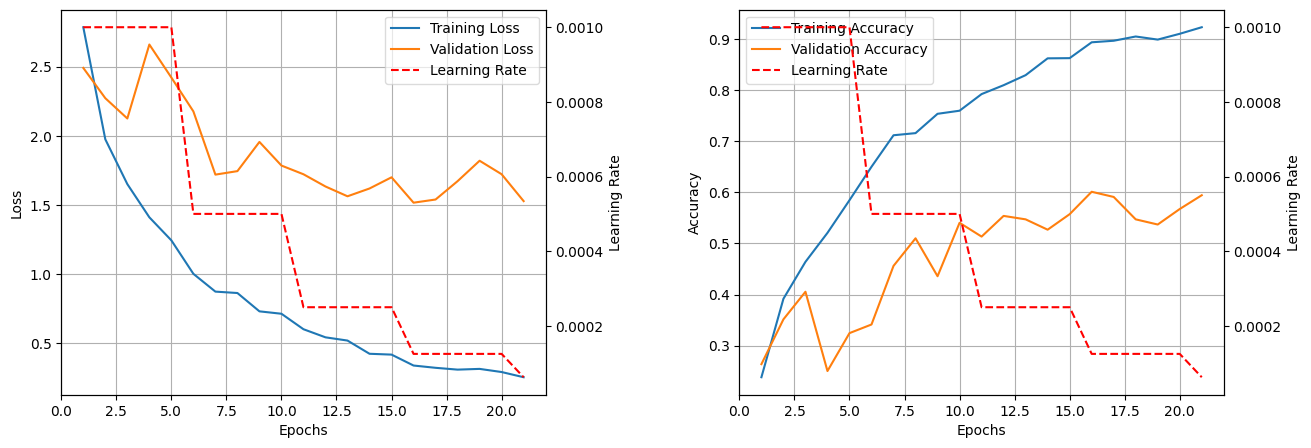

In [57]:
# Initialize the model, loss function, and optimizer
model = Model4(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) 
best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    scheduler = scheduler,
    patience_epochs=5
)

In [58]:
params = {
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': 'dropout, batch norm',
    'avg pool': True,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
results[model.get_name()+'with_step_lr'] = params

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 2.744 - train acc 0.245 - valid loss 2.855 - valid acc 0.267
Epoch 6: train loss 1.052 - train acc 0.637 - valid loss 1.607 - valid acc 0.459
Epoch 11: train loss 0.838 - train acc 0.733 - valid loss 1.557 - valid acc 0.551
Epoch 16: train loss 0.778 - train acc 0.758 - valid loss 1.480 - valid acc 0.574
Epoch 21: train loss 0.774 - train acc 0.755 - valid loss 1.522 - valid acc 0.541
Early stopping at epoch 21
Best epoch 16, best acc 0.574


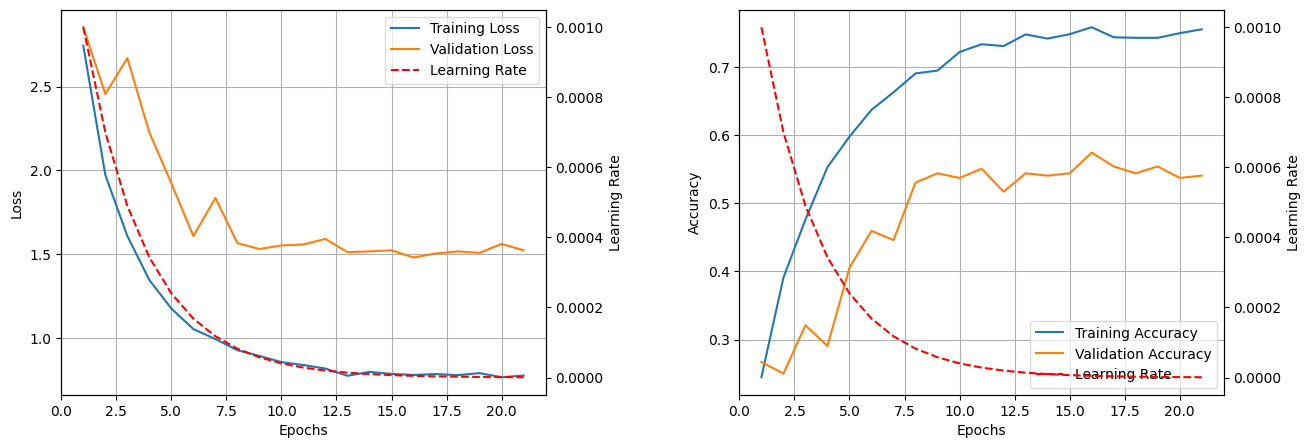

In [59]:
# Initialize the model, loss function, and optimizer
model = Model4(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)
best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    max_epochs,
    optimizer,
    val_dl,
    verbose=True,
    scheduler = scheduler,
    patience_epochs=5
)

## **Changing the input size** ##

Lets see if changing the input size effects our performance. 

We observed in Fully connected network that it decreased the performance, but we are hopeful in VGG style network since we are using convolution network and they work better on higher resolution as we have seen in the class.

In [60]:
batch_size = 128
num_workers = 4

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 2.754 - train acc 0.256 - valid loss 2.972 - valid acc 0.169
Epoch 6: train loss 1.182 - train acc 0.602 - valid loss 3.113 - valid acc 0.226
Early stopping at epoch 10
Best epoch 5, best acc 0.385


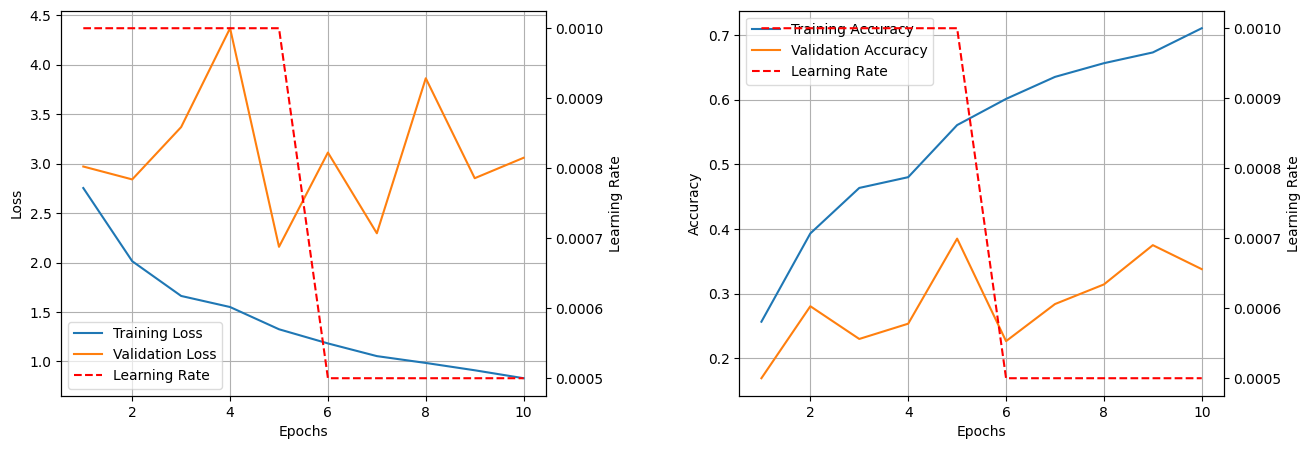

In [61]:
# Initialize the model, loss function, and optimizer
model = Model4(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl_128,
    max_epochs,
    optimizer,
    val_dl_128,
    verbose=True,
    scheduler = scheduler,
    patience_epochs=5
)

In [62]:
params = {
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': 'dropout, batch norm',
    'avg pool': True,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
results[model.get_name()+'with_step_lr'] = params

## **Adam with weight decay and Leaky ReLU** ##

In [63]:
class Model5(nn.Module):
  '''
  A VGG inspired CNN with dropout regularization + global average pooling + batch normalization + Leaky ReLU.
  '''
  def __init__(self, n_classes: int):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), 
    nn.LeakyReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), 
    nn.LeakyReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), 
    nn.LeakyReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), 
    nn.LeakyReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1, 1))
    )
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(512, 1024),
        nn.LeakyReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(1024, n_classes)
    )

  def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

  def get_name(self):
      return "Model5"

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 2.768 - train acc 0.236 - valid loss 3.705 - valid acc 0.226
Epoch 6: train loss 1.175 - train acc 0.598 - valid loss 3.252 - valid acc 0.260
Epoch 11: train loss 0.797 - train acc 0.728 - valid loss 2.145 - valid acc 0.351
Epoch 16: train loss 0.592 - train acc 0.805 - valid loss 1.549 - valid acc 0.571
Epoch 21: train loss 0.454 - train acc 0.857 - valid loss 1.497 - valid acc 0.578
Epoch 26: train loss 0.413 - train acc 0.864 - valid loss 1.476 - valid acc 0.581
Epoch 31: train loss 0.392 - train acc 0.875 - valid loss 1.420 - valid acc 0.625
Epoch 36: train loss 0.378 - train acc 0.878 - valid loss 1.446 - valid acc 0.611
Early stopping at epoch 36
Best epoch 31, best acc 0.625


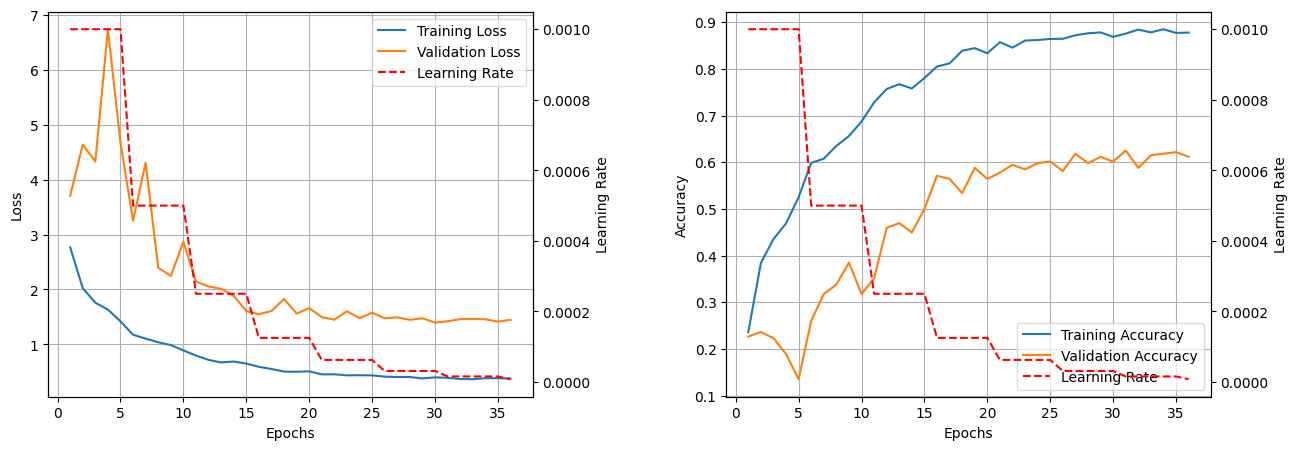

In [64]:
# Initialize the model, loss function, and optimizer
model = Model5(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl_128,
    max_epochs,
    optimizer,
    val_dl_128,
    verbose=True,
    scheduler = scheduler,
    patience_epochs=5
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 2.693 - train acc 0.269 - valid loss 2.986 - valid acc 0.169
Epoch 6: train loss 1.179 - train acc 0.581 - valid loss 2.323 - valid acc 0.422
Epoch 11: train loss 0.696 - train acc 0.765 - valid loss 1.756 - valid acc 0.517
Epoch 16: train loss 0.514 - train acc 0.827 - valid loss 1.625 - valid acc 0.561
Epoch 21: train loss 0.414 - train acc 0.870 - valid loss 1.509 - valid acc 0.564
Epoch 26: train loss 0.361 - train acc 0.888 - valid loss 1.553 - valid acc 0.564
Early stopping at epoch 28
Best epoch 23, best acc 0.611


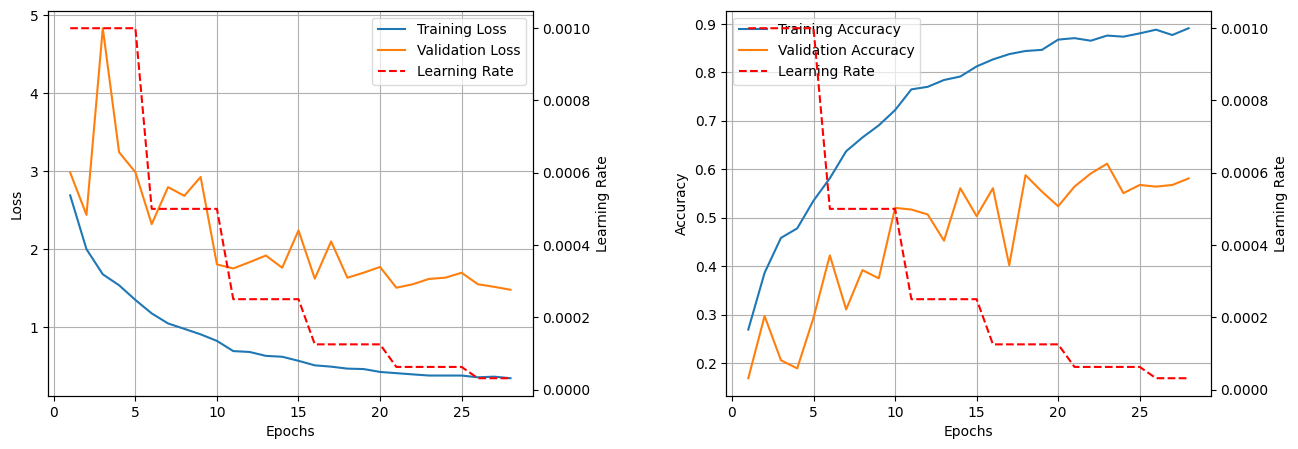

In [66]:
# Initialize the model, loss function, and optimizer
model = Model5(n_classes=n_classes).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl_128,
    max_epochs,
    optimizer,
    val_dl_128,
    verbose=True,
    scheduler = scheduler,
    patience_epochs=5
)

In [67]:
params = {
    'input size': size,
    'learning rate': learning_rate,
    'regularization': 'dropout, batch norm',
    'avg pool': True,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
results[model.get_name()+'with_leaky_relu_and_AdamW'] = params

In [68]:
results

{'Baseline': {'input size': 64,
  'learning rate': 0.001,
  'regularization': None,
  'avg pool': False,
  'validation accuracy': 0.20608108108108109,
  'epoch': 4},
 'Baseline_128': {'input size': 128,
  'learning rate': 0.001,
  'regularization': None,
  'avg pool': False,
  'validation accuracy': 0.09797297297297297,
  'epoch': 2},
 'Model1': {'input size': 128,
  'learning rate': 0.001,
  'regularization': None,
  'avg pool': False,
  'validation accuracy': 0.30743243243243246,
  'epoch': 5},
 'Model2': {'input size': 128,
  'learning rate': 0.001,
  'regularization': 'dropout',
  'avg pool': False,
  'validation accuracy': 0.32432432432432434,
  'epoch': 5},
 'Model3': {'input size': 128,
  'learning rate': 0.001,
  'regularization': 'dropout',
  'avg pool': True,
  'validation accuracy': 0.42567567567567566,
  'epoch': 5},
 'Model4': {'input size': 128,
  'learning rate': 0.001,
  'regularization': 'dropout, batch norm',
  'avg pool': True,
  'validation accuracy': 0.533783783783

In [69]:
torch.save(best_params, "part1_best_model.pth")

Test Accuracy: 66.48%


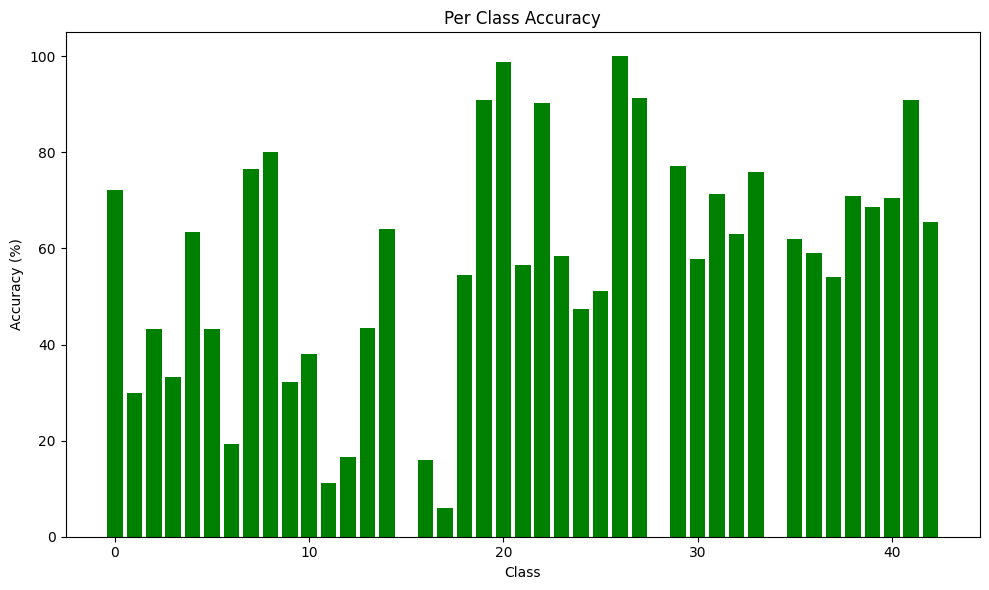

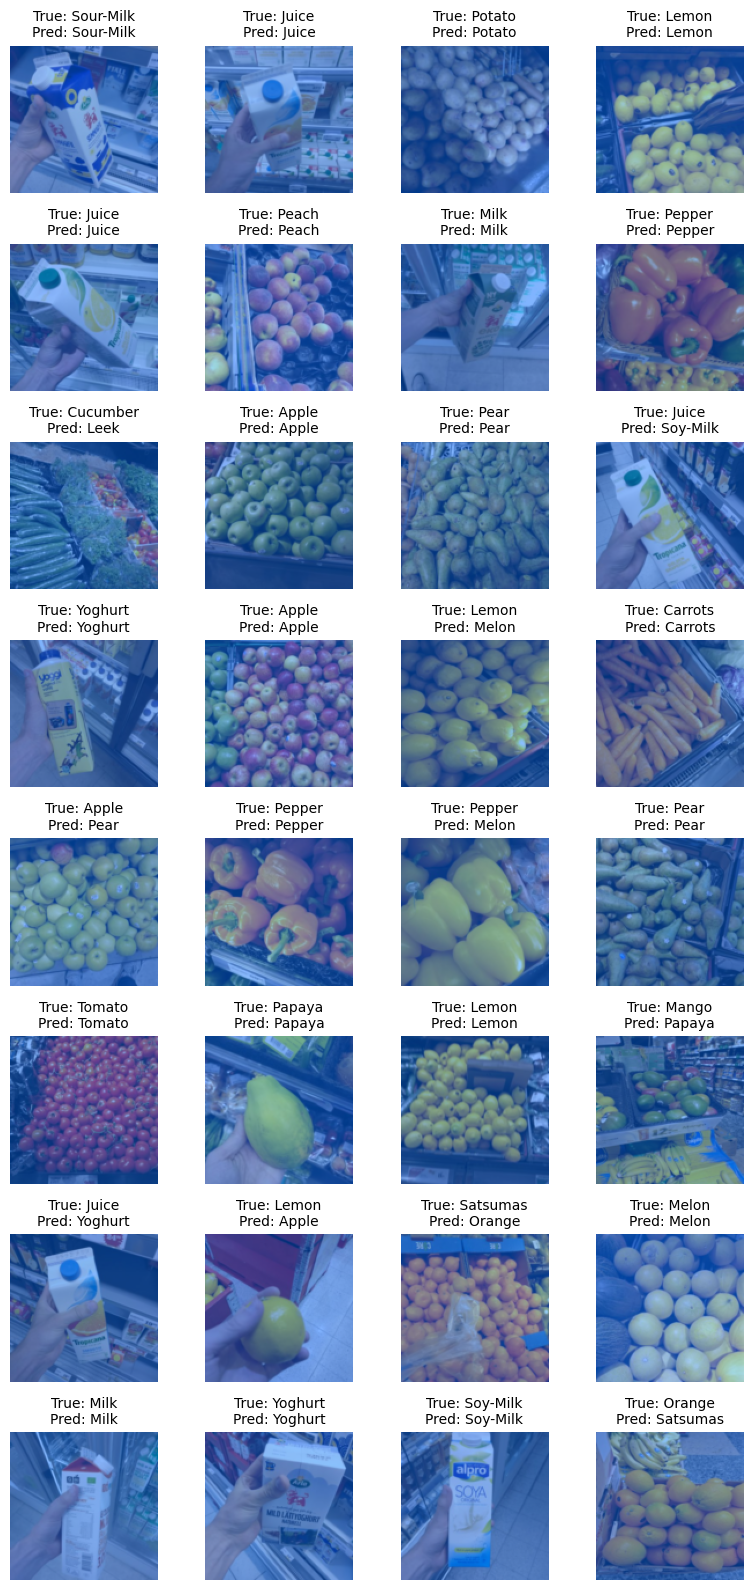

In [70]:
model = Model5(n_classes=n_classes).to(device)
weights = torch.load("part1_best_model.pth", weights_only=True)
test_model(model, weights, test_dl_128, samples=32)

In [71]:
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.sort_values(by='validation accuracy', ascending=False, axis=0)

input size   learning rate  \
Model5with_leaky_relu_and_AdamW         128           0.001   
Model4                                  128           0.001   
Model3                                  128           0.001   
Model4with_step_lr                      128  step scheduler   
Model2                                  128           0.001   
Model1                                  128           0.001   
Baseline                                 64           0.001   
Baseline_128                            128           0.001   

                                      regularization  avg pool  \
Model5with_leaky_relu_and_AdamW  dropout, batch norm      True   
Model4                           dropout, batch norm      True   
Model3                                       dropout      True   
Model4with_step_lr               dropout, batch norm      True   
Model2                                       dropout     False   
Model1                                          None     False   
Baseline                                        None     False   
Baseline_128                                    None     False   

                                 validation accuracy  epoch  
Model5with_leaky_relu_and_AdamW             0.611486     23  
Model4                                      0.533784     17  
Model3                                      0.425676      5  
Model4with_step_lr                          0.385135      5  
Model2                                      0.324324      5  
Model1                                      0.307432      5  
Baseline                                    0.206081      4  
Baseline_128                                0.097973      2

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

In [72]:
##dictionary to store the results of all the expereriments!!
resnet_results = {}

In [73]:
def unfreeze_layers(model, layers_to_unfreeze):
    """
    Freeze all layers in a model except for the ones specified in layers_to_unfreeze,
    and print the details about the frozen and unfrozen layers along with parameter counts.

    Args:
        model (nn.Module): The PyTorch model.
        layers_to_unfreeze (List[str]): List of layer names to remain trainable.

    Returns:
        None
    """
    total_params, trainable_params = 0, 0
    frozen_layers, unfrozen_layers = [], []
    all_layer_names = [name for name, _ in model.named_children()]
    
    # Check if layers_to_unfreeze is empty, meaning all layers should be frozen
    if not layers_to_unfreeze:
        print("All layers are frozen")
        for param in model.parameters():
            param.requires_grad = True
            total_params += param.numel()
        trainable_params = total_params
    else:
        found_any = False  # Track if any layer was actually unfrozen
        for name, child in model.named_children():
            if name in layers_to_unfreeze:
                print(f"{name} is unfrozen")
                for param in child.parameters():
                    param.requires_grad = True
                    trainable_params += param.numel()
                    total_params += param.numel()
                unfrozen_layers.append(name)
                found_any = True
            else:
                for param in child.parameters():
                    param.requires_grad = False
                    total_params += param.numel()
                frozen_layers.append(name)
        
        # If no layers were unfrozen, print all layer names
        if not found_any:
            print("Warning: None of the specified layers were found to unfreeze!")
            print("Available layers:")
            for layer in all_layer_names:
                print(f"  {layer}")
    
    # Print the layer statuses
    print("\nFrozen layers:")
    for layer in frozen_layers:
        print(f"  {layer}")
    
    print("\nUnfrozen layers:")
    for layer in unfrozen_layers:
        print(f"  {layer}")
    
    # Print parameter counts
    print(f"\nTotal parameters count: {total_params}")
    print(f"Trainable parameters count: {trainable_params}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


All layers are unfrozen

Frozen layers:

Unfrozen layers:

Total parameters count: 11198571
Trainable parameters count: 11198571


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 1.158 - train acc 0.686 - valid loss 3.306 - valid acc 0.389
Epoch 6: train loss 0.117 - train acc 0.968 - valid loss 2.361 - valid acc 0.497
Epoch 11: train loss 0.005 - train acc 0.998 - valid loss 1.142 - valid acc 0.696
Epoch 16: train loss 0.001 - train acc 1.000 - valid loss 1.026 - valid acc 0.740
Epoch 21: train loss 0.001 - train acc 1.000 - valid loss 0.981 - valid acc 0.757
Epoch 26: train loss 0.001 - train acc 1.000 - valid loss 0.964 - valid acc 0.770
Epoch 31: train loss 0.001 - train acc 1.000 - valid loss 1.126 - valid acc 0.747
Early stopping at epoch 31
Best epoch 26, best acc 0.770


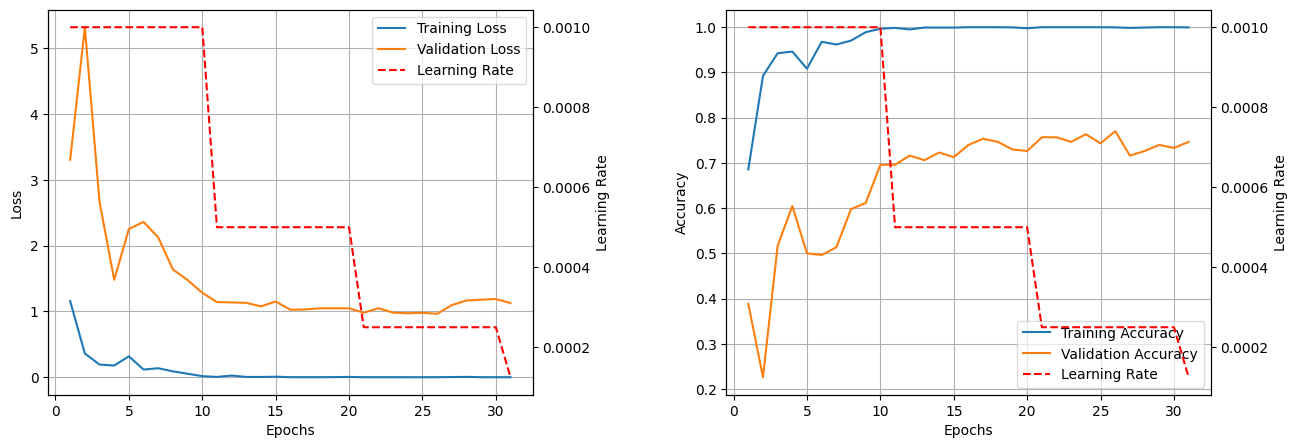

In [74]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # Necessary to adjust the output classes for our task
unfreeze_layers(model, []) # we're not freezing any layer
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl_128,
    max_epochs,
    optimizer,
    val_dl_128,
    verbose=True,
    scheduler = scheduler,
    patience_epochs=5
)

In [75]:
params = {
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': None,
    'unfreezed layers': None,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
resnet_results['ResNet18_128'] = params

## **Hyper parameter tuning** ##

ResNet is trained on 224 x 224

The Data have: 
size = (224, 224)
normalization = True


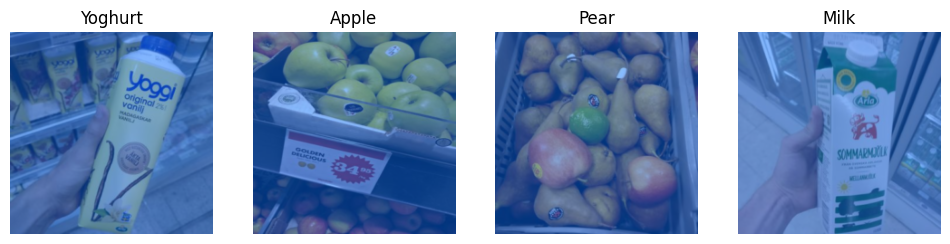

In [76]:
size = 224

transform = T.Compose([
    T.ToTensor(),
    T.Resize((size,size)),
    T.Normalize(mean=mean, std=std)
])

train_dataset_224 = GroceryStoreDataset(split='train', transform=transform)
val_dataset_224 = GroceryStoreDataset(split='val', transform=transform)
test_dataset_224  = GroceryStoreDataset(split='test', transform=transform)

batch_size = 128
num_workers = 1

train_dl_224 = DataLoader(
    train_dataset_224,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
val_dl_224 = DataLoader(
    val_dataset_224,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
test_dl_224 = DataLoader(
    test_dataset_224,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

plot_data(train_dataset_224, size=size, normalization=True)

All layers are unfrozen

Frozen layers:

Unfrozen layers:

Total parameters count: 11198571
Trainable parameters count: 11198571


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 1.048 - train acc 0.726 - valid loss 2.593 - valid acc 0.432
Epoch 6: train loss 0.034 - train acc 0.991 - valid loss 1.468 - valid acc 0.615
Epoch 11: train loss 0.016 - train acc 0.997 - valid loss 1.183 - valid acc 0.672
Epoch 16: train loss 0.001 - train acc 1.000 - valid loss 0.809 - valid acc 0.797
Early stopping at epoch 19
Best epoch 14, best acc 0.801


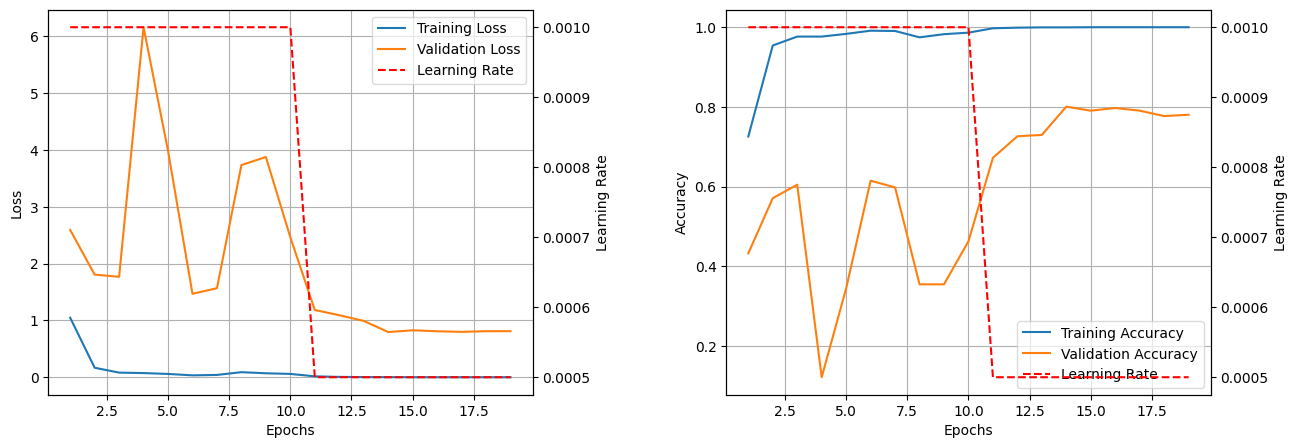

In [77]:
# Initialize the model, loss function, and optimizer
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
unfreeze_layers(model, []) # we're not freezing any layer
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl_224,
    max_epochs,
    optimizer,
    val_dl_224,
    verbose=True,
    scheduler = scheduler,
    patience_epochs=5
)

In [78]:
params = {
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': None,
    'unfreezed layers': None,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
resnet_results['ResNet18_224'] = params

## **Data Agumentation** ##

In [79]:
size = 224

transform_train = T.Compose([
    T.ToTensor(),
    T.Resize((size,size)), # set image resolution to (224,224) #
    T.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally #
    T.RandomRotation(30),      # Randomly rotate the image by 30 degrees #
    T.Normalize(mean=mean, std=std)

])

train_dataset_224_augment = GroceryStoreDataset(split='train', transform=transform_train)

batch_size = 128
num_workers = 1

train_dl_224_augment = DataLoader(
    train_dataset_224,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

All layers are unfrozen

Frozen layers:

Unfrozen layers:

Total parameters count: 11198571
Trainable parameters count: 11198571


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 1.003 - train acc 0.741 - valid loss 2.937 - valid acc 0.368
Epoch 6: train loss 0.027 - train acc 0.995 - valid loss 1.501 - valid acc 0.669
Epoch 11: train loss 0.018 - train acc 0.996 - valid loss 0.957 - valid acc 0.740
Epoch 16: train loss 0.001 - train acc 1.000 - valid loss 0.708 - valid acc 0.824
Epoch 21: train loss 0.000 - train acc 1.000 - valid loss 0.697 - valid acc 0.824
Early stopping at epoch 23
Best epoch 18, best acc 0.831


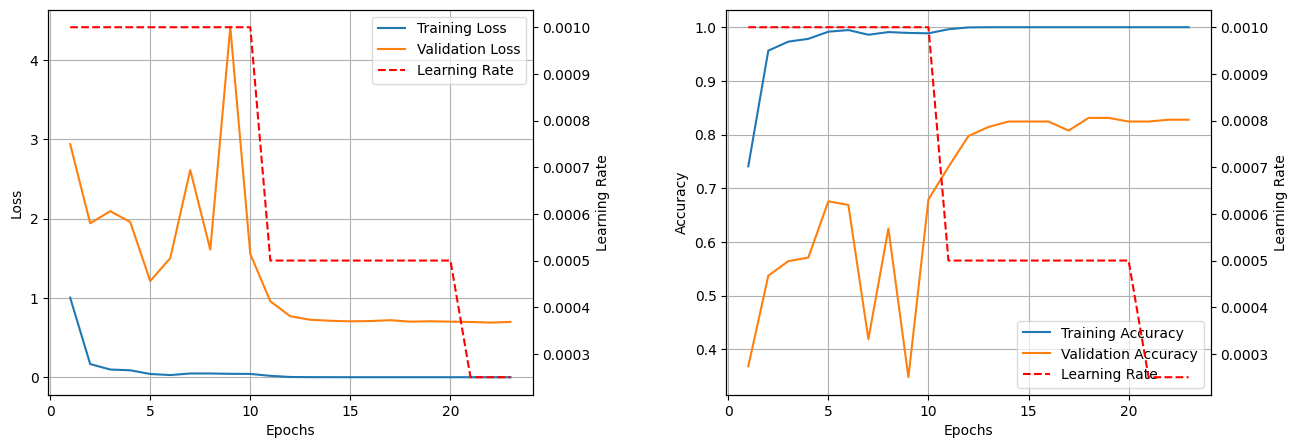

In [80]:
# Initialize the model, loss function, and optimizer
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
unfreeze_layers(model, []) # we're not freezing any layer
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl_224_augment,
    max_epochs,
    optimizer,
    val_dl_224,
    verbose=True,
    scheduler = scheduler,
    patience_epochs=5
)

In [81]:
params = {
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': 'data augmentation',
    'unfreezed layers': None,
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
resnet_results['ResNet18_dataaugmentation'] = params

fc is unfrozen

Frozen layers:
  conv1
  bn1
  relu
  maxpool
  layer1
  layer2
  layer3
  layer4
  avgpool

Unfrozen layers:
  fc

Total parameters count: 11198571
Trainable parameters count: 22059


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 2.986 - train acc 0.235 - valid loss 2.714 - valid acc 0.280
Epoch 6: train loss 0.694 - train acc 0.894 - valid loss 1.330 - valid acc 0.659
Epoch 11: train loss 0.346 - train acc 0.967 - valid loss 1.096 - valid acc 0.709
Epoch 16: train loss 0.267 - train acc 0.978 - valid loss 1.049 - valid acc 0.716
Epoch 21: train loss 0.213 - train acc 0.986 - valid loss 0.998 - valid acc 0.733
Epoch 26: train loss 0.194 - train acc 0.986 - valid loss 0.975 - valid acc 0.747
Epoch 31: train loss 0.173 - train acc 0.990 - valid loss 0.962 - valid acc 0.743
Early stopping at epoch 33
Best epoch 28, best acc 0.750


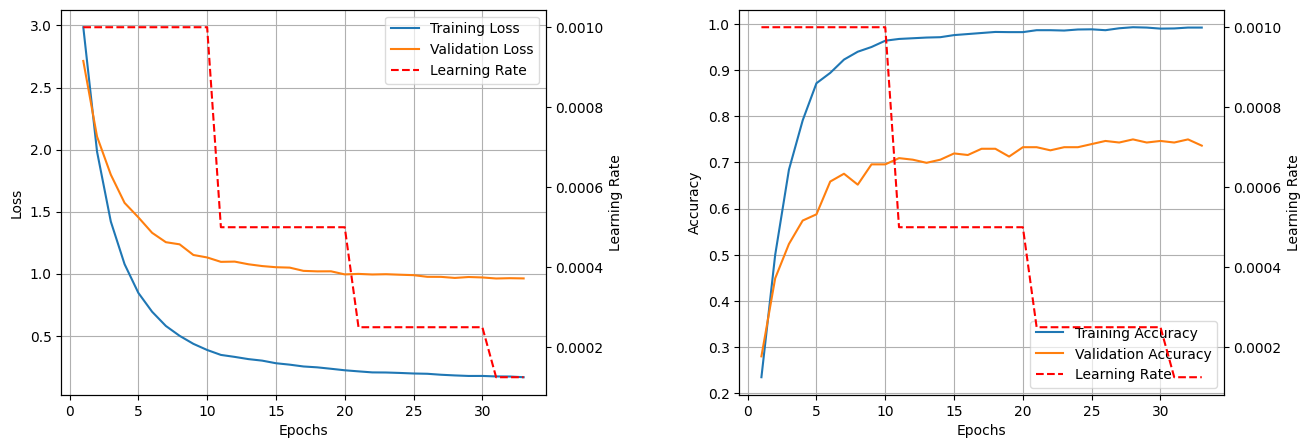

In [83]:
# Initialize the model, loss function, and optimizer
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
unfreeze_layers(model, ['fc']) # we're not freezing any layer
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl_224_augment,
    max_epochs,
    optimizer,
    val_dl_224,
    verbose=True,
    scheduler = scheduler,
    patience_epochs=5
)

In [85]:
params = {
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': 'data augmentation',
    'unfreezed layers': 'fc',
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
resnet_results['ResNet18_dataaugmentation'] = params

layer4 is unfrozen
fc is unfrozen

Frozen layers:
  conv1
  bn1
  relu
  maxpool
  layer1
  layer2
  layer3
  avgpool

Unfrozen layers:
  layer4
  fc

Total parameters count: 11198571
Trainable parameters count: 8415787


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 0.955 - train acc 0.762 - valid loss 0.983 - valid acc 0.696
Epoch 6: train loss 0.004 - train acc 0.999 - valid loss 0.623 - valid acc 0.824
Early stopping at epoch 8
Best epoch 3, best acc 0.851


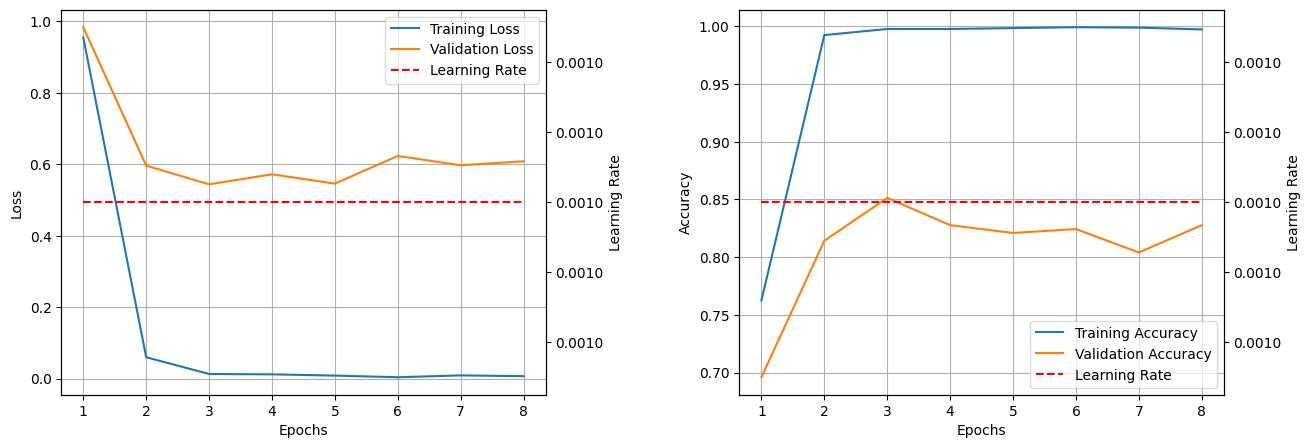

In [96]:
# Initialize the model, loss function, and optimizer
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
unfreeze_layers(model, ['fc','layer4']) # we're not freezing any layer
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl_224_augment,
    max_epochs,
    optimizer,
    val_dl_224,
    verbose=True,
    scheduler = scheduler,
    patience_epochs=5
)

In [87]:
params = {
    'input size': size,
    'learning rate': 'step scheduler',
    'regularization': 'data augmentation',
    'unfreezed layers': ['fc','layer4'],
    'validation accuracy': best_val_acc,
    'epoch': best_epoch
}
resnet_results['ResNet18_dataaugmentation'] = params

In [98]:
torch.save(best_params, "part2_best_model.pth")

layer3 is unfrozen
layer4 is unfrozen
fc is unfrozen

Frozen layers:
  conv1
  bn1
  relu
  maxpool
  layer1
  layer2
  avgpool

Unfrozen layers:
  layer3
  layer4
  fc

Total parameters count: 11198571
Trainable parameters count: 10515499


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 0.971 - train acc 0.755 - valid loss 1.510 - valid acc 0.578
Epoch 6: train loss 0.012 - train acc 0.997 - valid loss 0.811 - valid acc 0.814
Epoch 11: train loss 0.031 - train acc 0.992 - valid loss 1.010 - valid acc 0.747
Early stopping at epoch 11
Best epoch 6, best acc 0.814


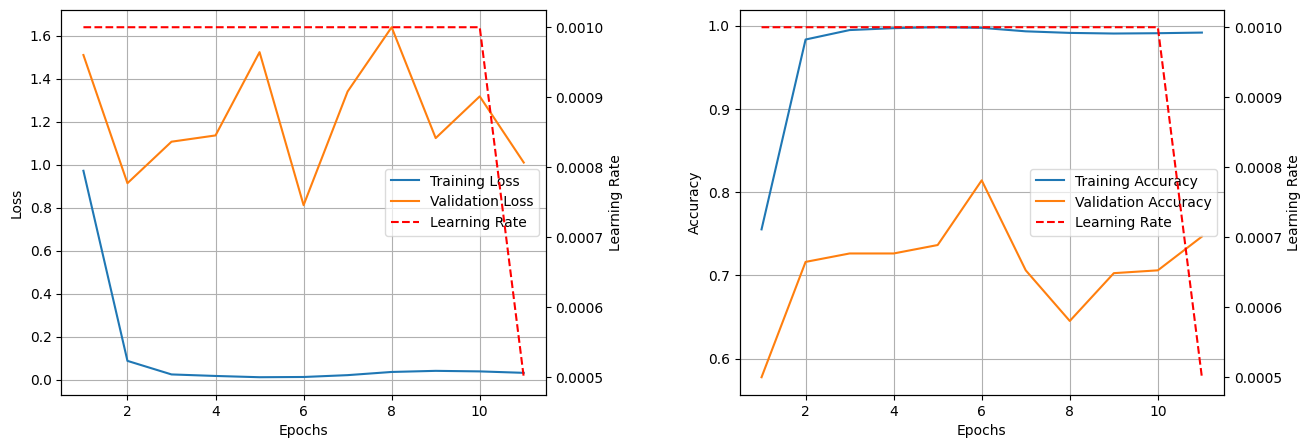

In [88]:
# Initialize the model, loss function, and optimizer
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
unfreeze_layers(model, ['fc','layer4','layer3']) # we're not freezing any layer
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl_224_augment,
    max_epochs,
    optimizer,
    val_dl_224,
    verbose=True,
    scheduler = scheduler,
    patience_epochs=5
)

layer2 is unfrozen
layer3 is unfrozen
layer4 is unfrozen
fc is unfrozen

Frozen layers:
  conv1
  bn1
  relu
  maxpool
  layer1
  avgpool

Unfrozen layers:
  layer2
  layer3
  layer4
  fc

Total parameters count: 11198571
Trainable parameters count: 11041067


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 1.032 - train acc 0.732 - valid loss 2.131 - valid acc 0.486
Epoch 6: train loss 0.018 - train acc 0.996 - valid loss 0.853 - valid acc 0.747
Epoch 11: train loss 0.022 - train acc 0.996 - valid loss 1.021 - valid acc 0.736
Early stopping at epoch 11
Best epoch 6, best acc 0.747


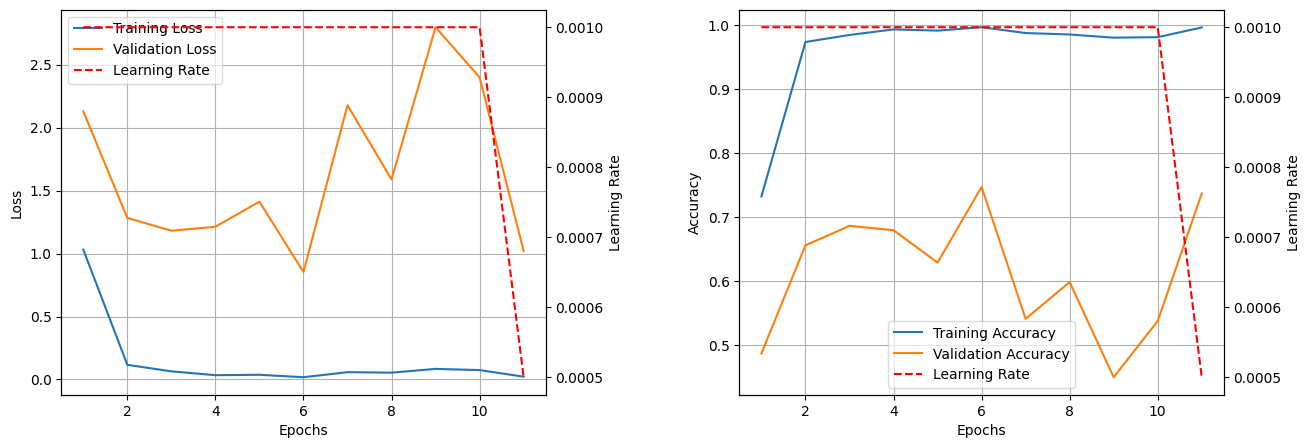

In [90]:
# Initialize the model, loss function, and optimizer
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
unfreeze_layers(model, ['fc','layer4','layer3','layer2']) # we're not freezing any layer
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl_224_augment,
    max_epochs,
    optimizer,
    val_dl_224,
    verbose=True,
    scheduler = scheduler,
    patience_epochs=5
)

layer1 is unfrozen
layer2 is unfrozen
layer3 is unfrozen
layer4 is unfrozen
fc is unfrozen

Frozen layers:
  conv1
  bn1
  relu
  maxpool
  avgpool

Unfrozen layers:
  layer1
  layer2
  layer3
  layer4
  fc

Total parameters count: 11198571
Trainable parameters count: 11189035


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 1.017 - train acc 0.734 - valid loss 3.177 - valid acc 0.480
Epoch 6: train loss 0.028 - train acc 0.993 - valid loss 1.882 - valid acc 0.581
Early stopping at epoch 8
Best epoch 3, best acc 0.699


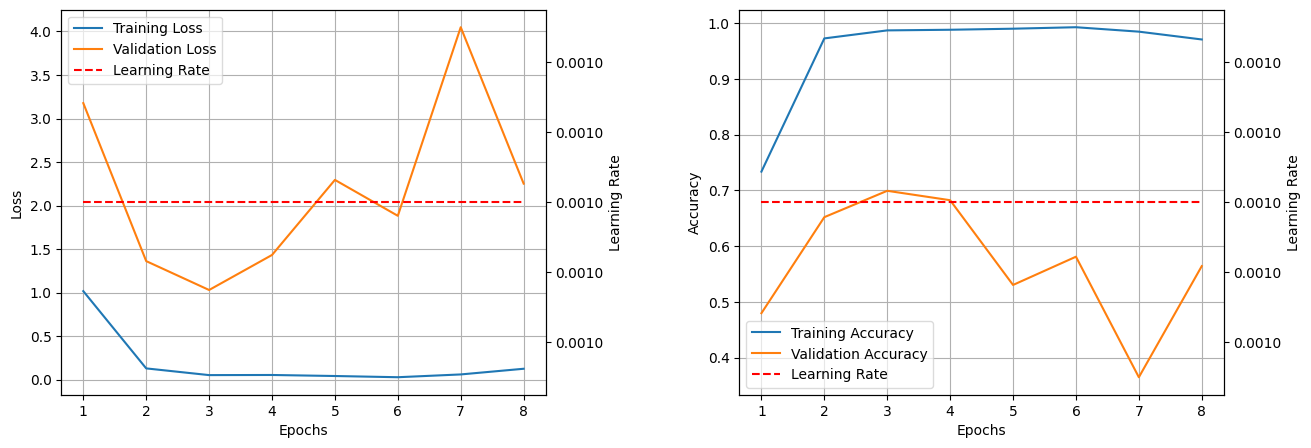

In [93]:
# Initialize the model, loss function, and optimizer
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
unfreeze_layers(model, ['fc','layer4','layer3','layer2','layer1']) # we're not freezing any layer
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl_224_augment,
    max_epochs,
    optimizer,
    val_dl_224,
    verbose=True,
    scheduler = scheduler,
    patience_epochs=5
)

conv1 is unfrozen
layer1 is unfrozen
layer2 is unfrozen
layer3 is unfrozen
layer4 is unfrozen
fc is unfrozen

Frozen layers:
  bn1
  relu
  maxpool
  avgpool

Unfrozen layers:
  conv1
  layer1
  layer2
  layer3
  layer4
  fc

Total parameters count: 11198571
Trainable parameters count: 11198443


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: train loss 1.119 - train acc 0.707 - valid loss 3.586 - valid acc 0.321
Epoch 6: train loss 0.041 - train acc 0.991 - valid loss 1.447 - valid acc 0.662
Early stopping at epoch 9
Best epoch 4, best acc 0.669


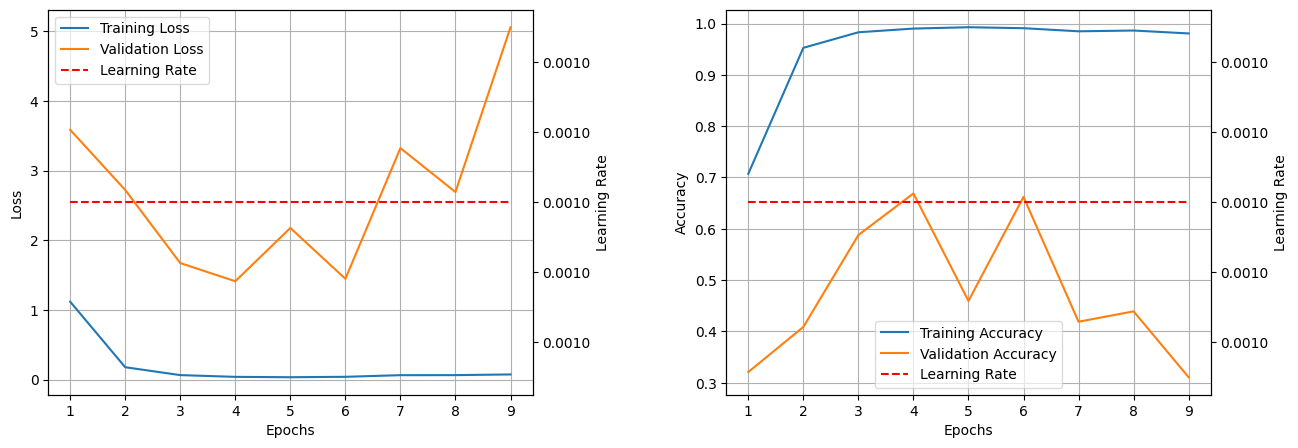

In [95]:
# Initialize the model, loss function, and optimizer
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
unfreeze_layers(model, ['fc','layer4','layer3','layer2','layer1','conv1']) # we're not freezing any layer
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl_224_augment,
    max_epochs,
    optimizer,
    val_dl_224,
    verbose=True,
    scheduler = scheduler,
    patience_epochs=5
)

In [99]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # Necessary to adjust the output classes for our task
model = model.to(device)
weights = torch.load("part2_best_model.pth", weights_only=True)

In [ ]:
test_model(model, weights, test_dl_224, samples=32)

In [ ]:
resnet_summary_df = pd.DataFrame.from_dict(resnet_summary, orient='index')
resnet_summary_df.sort_values(by='validation accuracy', ascending=False, axis=0)

In [ ]:
import pandas as pd